<a href="https://colab.research.google.com/github/RachelRamirez/CIFAR-10/blob/main/CollectionofTests/Test-2-Group-A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Date: Last changed 11/10/2021 at 0825


Description:  trying one image per class yields about 0.1 Test Accuracy, with SHARD = 4000.

# Imports

In [109]:
#@title import libraries set time
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import copy
import os
import PIL
import PIL.Image
from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
# import keras.utils -- dont do this!! it causes problems, 
from tensorflow.keras.utils import to_categorical  #do this instead!!
import random
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import time
import pickle
from google.colab import files
import datetime # to display the current time hh:mm:ss

# Possibly Need IMGAUG to set seed in ALbumentations
# GitHub Issue: https://github.com/albumentations-team/albumentations/issues/93
import imgaug
imgaug.seed(123)


tic = time.time()  # Start the timer
initial_run = 0

AUTOTUNE = tf.data.experimental.AUTOTUNE
np.set_printoptions(precision=4)

### Set Random Seeds

In [110]:
seed = 42
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed()  # https://stackoverflow.com/questions/11526975/set-random-seed-programwide-in-python
shuffle_seed = seed
## ------------------

Set Logic-Values


In [111]:
run_model = False  #When Im looking at augmentations, I don't want to keep refitting a model, I want to just get the database of images loaded

Make Image Datasets

One of my biggest learning curves was learning how to load  the dataset with tdfs.load() and then filter on images by label.  

The second biggest was using the created model to make predictions on the test set.   

Current but "skipped" problem is trying to view misclassifeid images of results.


Another area of problems is rerunning when you've already specified a batch on your dataset creates another "batch" split so it can cause problems to rerun a cell that says how to define a dataset.  Unbatch may be needed first.    

,image,label
0,,7 (horse)
1,,8 (ship)
2,,4 (deer)
3,,4 (deer)
4,,6 (frog)

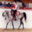
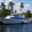
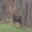
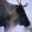
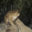

In [200]:
#@title DatasetBuildingLoading

# A weird problem happened where it said the toronto website cant be reached, if that ever happens again make sure to go to SO for this advice https://stackoverflow.com/questions/36805640/this-error-while-downloading-datasets-valueerror-i-o-operation-on-closed-file

# How do I set IDs on: read_config.add_tfds_id = True
read_config = tfds.ReadConfig(shuffle_seed=seed) 
read_config.add_tfds_id = True  ## This didnt update ReadConfig 

dataset, info = tfds.load('cifar10', as_supervised=True, with_info=True, read_config=read_config)
x_test =  dataset["test"]
dataset  = dataset["train"]
assert isinstance(x_test, tf.data.Dataset)
#x_test = [(example.numpy(), label.numpy()) for example, label in x_test]
# once broken into numpy arrays, my model still doesn't handle it, it seems to be expecting a tensor
# So i think i have to break it into two tensors?  test_x, test_y?
# x_test[0][0]
# x_test[0][1]
# x_test = pd.DataFrame(x_test, columns=['example', 'label'])
# x_test = tf.data.Dataset.from_generator(lambda: x_test, (tf.int64, tf.int16))
# x_list = list(x_test.as_numpy_iterator())  # Crashes Google Colab!
# print(x_list[:5])


#  I got this from stack-overflow.  Need this code to define y_test, the labels of testset

def get_labels_from_tfdataset(tfdataset, batched=False):
    labels = list(map(lambda x: x[1], tfdataset)) # Get labels 
    if not batched:
        return tf.concat(labels, axis=0) # concat the list of batched labels
    return labels
y_test = get_labels_from_tfdataset(x_test)

# tfds.as_dataframe(dataset.take(5), info)  #does not display image ID :-( )

dataset_airplanes   = dataset.filter(lambda img, label: label == 0)
dataset_automobiles = dataset.filter(lambda img, label: label == 1)
dataset_birds       = dataset.filter(lambda img, label: label == 2)
dataset_cats        = dataset.filter(lambda img, label: label == 3)
dataset_deers       = dataset.filter(lambda img, label: label == 4)
dataset_dogs        = dataset.filter(lambda img, label: label == 5)
dataset_frogs       = dataset.filter(lambda img, label: label == 6)
dataset_horses      = dataset.filter(lambda img, label: label == 7)
dataset_ships       = dataset.filter(lambda img, label: label == 8)
dataset_trucks      = dataset.filter(lambda img, label: label == 9)

##  Ways to count the number of images in the sets:
print("There are ways to count and verify the number per training set which i have hidden because they are costly")
print("Entire Training Dataset was originally cardinality:", tf.data.experimental.cardinality(dataset).numpy()) #   prints 50,000, correct
print("Entire Airplane Training Dataset was originally cardinality:", tf.data.experimental.cardinality(dataset_airplanes).numpy()) #   prints -2 this is a "feature" in tf when a set takes too long to count
# print(dataset_airplanes.reduce(np.int64(0), lambda x,_ : x + 1).numpy()) #prints 5000, correct

##  This is a way of asserting that all the images have the same label in a set
# for img, label in dataset_dogs:
#   assert label == 5
 

In [262]:
#@title Counting the Number of Each Class Function 'count_cifar10_class'
# define a fuction to count the numbre of each class
# I'm not going to worry about it now, but if i had time to cleanup code I would 
# Try to use this type of if/zip structure  https://stackoverflow.com/questions/57784643/if-statement-and-zip

 
def count_cifar10_class(datasetpassed):
  # takes the datasetpassed and returns the number of each category as a ten-tupple
   
  num_airplanes, num_automobiles, num_birds, num_cats, num_deers = 0,0,0,0,0
  num_dogs, num_frogs, num_horses, num_ships, num_trucks= 0, 0, 0,0,0

  for img, label in datasetpassed:
    if label == 0:
      num_airplanes += 1

    if label == 1:
      num_automobiles += 1

    if label == 2:
      num_birds +=1

    if label == 3:
      num_cats +=1

    if label ==4: 
      num_deers += 1

    if label == 5:
       num_dogs += 1 

    if label == 6:
        num_frogs += 1

    if label == 7:
      num_horses += 1

    if label == 8:
      num_ships +=1 

    if label == 9: 
      num_trucks +=1

  return num_airplanes, num_automobiles, num_birds, num_cats, num_dogs, num_deers, num_dogs, num_frogs, num_horses, num_ships, num_trucks 



(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)

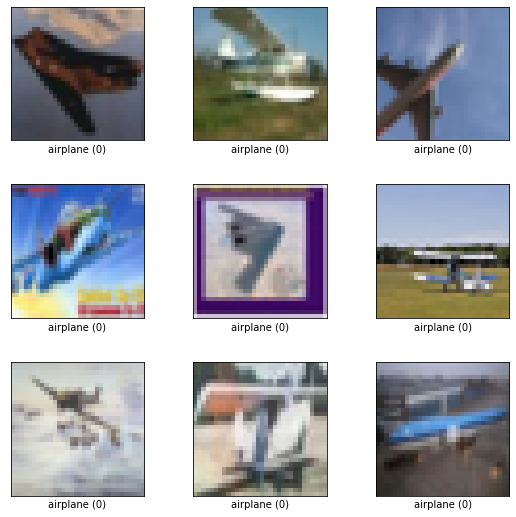

In [113]:
#@title ShowExamplesofDatasetAirplanes
## Tfds.show_examples is a matplotlib funnction that only works on image ds's, and you have to pass it the "info" for some reason
fig = tfds.show_examples(dataset_airplanes, info)

How to display one picture of a dataset using `next(iter(dataset)`

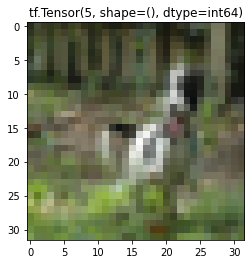

In [199]:
#@title ShowExampleofOneIterations of DatasetDogs
# I wish I could display ID!!

img, label = next(iter(dataset_dogs))
plt.title(str(label))
plt.imshow(img)

#0x7f6e309eff10?


# Create validation set of 10,000 images

In [115]:
#@title
# I want 10 un replicated samples from dataset_airplanes + dataset_automobiles... dataset_trucks.

# There are 5000 images of each Class 
# I want 10 equal sets A, B, C, D, ... J plus a validation set
# I want 10,000 total images in the validation set with 1000 of each class
# and I want 10 sets of training images  4000 total images, so 400 images in each class

N = 1000
dataset_airplanes_val   = dataset_airplanes.take(N)
dataset_automobiles_val  = dataset_automobiles.take(N)
dataset_birds_val       = dataset_birds.take(N)  
dataset_cats_val        = dataset_cats.take(N)
dataset_deers_val       = dataset_deers.take(N)
dataset_dogs_val        = dataset_dogs.take(N)
dataset_frogs_val       = dataset_frogs.take(N)
dataset_horses_val      = dataset_horses.take(N)
dataset_ships_val       = dataset_ships.take(N)
dataset_trucks_val      = dataset_trucks.take(N)


# Make sure to skip the next 1000 images in each data set before making training set
dataset_airplanes   = dataset_airplanes.skip(N)
dataset_automobiles  = dataset_automobiles.skip(N)
dataset_birds      = dataset_birds.skip(N)  
dataset_cats        = dataset_cats.skip(N)
dataset_deers       = dataset_deers.skip(N)
dataset_dogs        = dataset_dogs.skip(N)
dataset_frogs       = dataset_frogs.skip(N)
dataset_horses      = dataset_horses.skip(N)
dataset_ships       = dataset_ships.skip(N)
dataset_trucks      = dataset_trucks.skip(N)

# # Check that remaining dataset does not have validation data
# fig = tfds.show_examples(dataset_ships, info)
# fig = tfds.show_examples(dataset_ships_val, info)
# # I checked and they dont.


# NOW, How do I combine my val sets?

# Hint1 its not this... 
# val = dataset_airplanes_val + dataset_automobile_val + dataset_birds_val

# #  Hint2 its also not this implementation of zip because the info file doesn't match it
# val = tf.data.Dataset.zip((dataset_airplanes_val,
#                     dataset_automobile_val,
#                     dataset_birds_val,
#                     dataset_cats_val,
#                     dataset_deers_val,
#                     dataset_dogs_val,
#                     dataset_frogs_val,
#                     dataset_horses_val,
#                     dataset_ships_val,
#                     dataset_trucks_val ))
 
# fig = tfds.show_examples(val, info)   # Returns a warning that the info file is not compatible


# is it concatenate? YESSSSSSSSSSSSSSSSSSSSSS
val = dataset_airplanes_val.concatenate(dataset_automobiles_val)
# This is how I checked that it worked
# fig = tfds.show_examples(val.skip(999), info)    # shows 1 airplane and then 8 automobiles

val = val.concatenate(dataset_birds_val)
val = val.concatenate(dataset_cats_val)
val = val.concatenate(dataset_deers_val)
val = val.concatenate(dataset_dogs_val)
val = val.concatenate(dataset_frogs_val)
val = val.concatenate(dataset_horses_val)
val = val.concatenate(dataset_ships_val)
val = val.concatenate(dataset_trucks_val)
  
# print(val.reduce(np.int32(0), lambda x,_ : x + 1))  # this shows 10000! Thank goodness! :-)



# Create smaller groups of each CIFAR Class sets (set Shard)

After removing the 10,000 validation set from the training-data, the remaining set has 40,000 images, 4000 images of each class.  To create smaller training-datasets of similar sizes, shard the dataset into equal pieces.

For the initial days of testing I decided on **250 images** per class for my first couple runs, which equates to 16 shards (40,000/16 = 250) .  When I wanted to study what was going on more beneath the hood for my augmentations, I decided to make the training set even more tiny so I could view all the images per training set I decided to try 1 image per class so I could easily view all the images augmeted and not augmented.  This meant I needed **4000 shards!** for troubleshooting.



In [116]:
SHARDS=4000

#### Airplanes (airplanes_A, ... airplanes_P)

In [117]:
#@title
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shard

# Check that each of the remaining 10 datasets has only 4000 images 
# print(dataset_airplanes.reduce(np.int32(0), lambda x,_ : x + 1))  # 4000 check!

# Shard each of the remaining 10 datasets into 16 smaller groups
airplanes_A = dataset_airplanes.shard(num_shards=SHARDS, index = 0)
airplanes_B = dataset_airplanes.shard(num_shards=SHARDS, index = 1)
airplanes_C = dataset_airplanes.shard(num_shards=SHARDS, index = 2)
airplanes_D = dataset_airplanes.shard(num_shards=SHARDS, index = 3)
airplanes_E = dataset_airplanes.shard(num_shards=SHARDS, index = 4)
airplanes_F = dataset_airplanes.shard(num_shards=SHARDS, index = 5)
airplanes_G = dataset_airplanes.shard(num_shards=SHARDS, index = 6)
airplanes_H = dataset_airplanes.shard(num_shards=SHARDS, index = 7)
airplanes_I = dataset_airplanes.shard(num_shards=SHARDS, index = 8)
airplanes_J = dataset_airplanes.shard(num_shards=SHARDS, index = 9)
airplanes_K = dataset_airplanes.shard(num_shards=SHARDS, index = 10)
airplanes_L = dataset_airplanes.shard(num_shards=SHARDS, index = 11)
airplanes_M = dataset_airplanes.shard(num_shards=SHARDS, index = 12)
airplanes_N = dataset_airplanes.shard(num_shards=SHARDS, index = 13)
airplanes_O = dataset_airplanes.shard(num_shards=SHARDS, index = 14)
airplanes_P = dataset_airplanes.shard(num_shards=SHARDS, index = 15)

#check that a random airplane dataset only has 250 images
# print(airplanes_M.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!


#### Automobiles

In [118]:
#@title
# dataset_automobile

# Check that each of the remaining 10 datasets has only 4000 images 
# print(dataset_automobile.reduce(np.int32(0), lambda x,_ : x + 1))  # 4000 check!

# Shard each of the remaining 10 datasets into 16 smaller groups
automobiles_A = dataset_automobiles.shard(num_shards=SHARDS, index = 0)
automobiles_B = dataset_automobiles.shard(num_shards=SHARDS, index = 1)
automobiles_C = dataset_automobiles.shard(num_shards=SHARDS, index = 2)
automobiles_D = dataset_automobiles.shard(num_shards=SHARDS, index = 3)
automobiles_E = dataset_automobiles.shard(num_shards=SHARDS, index = 4)
automobiles_F = dataset_automobiles.shard(num_shards=SHARDS, index = 5)
automobiles_G = dataset_automobiles.shard(num_shards=SHARDS, index = 6)
automobiles_H = dataset_automobiles.shard(num_shards=SHARDS, index = 7)
automobiles_I = dataset_automobiles.shard(num_shards=SHARDS, index = 8)
automobiles_J = dataset_automobiles.shard(num_shards=SHARDS, index = 9)
automobiles_K = dataset_automobiles.shard(num_shards=SHARDS, index = 10)
automobiles_L = dataset_automobiles.shard(num_shards=SHARDS, index = 11)
automobiles_M = dataset_automobiles.shard(num_shards=SHARDS, index = 12)
automobiles_N = dataset_automobiles.shard(num_shards=SHARDS, index = 13)
automobiles_O = dataset_automobiles.shard(num_shards=SHARDS, index = 14)
automobiles_P = dataset_automobiles.shard(num_shards=SHARDS, index = 15)


#check that a random airplane dataset only has 250 images
# print(airplanes_H.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!

#### Birds

In [119]:
#@title
# dataset_birds

# Shard each of the remaining 10 datasets into 16 smaller groups
birds_A = dataset_birds.shard(num_shards=SHARDS, index = 0)
birds_B = dataset_birds.shard(num_shards=SHARDS, index = 1)
birds_C = dataset_birds.shard(num_shards=SHARDS, index = 2)
birds_D = dataset_birds.shard(num_shards=SHARDS, index = 3)
birds_E = dataset_birds.shard(num_shards=SHARDS, index = 4)
birds_F = dataset_birds.shard(num_shards=SHARDS, index = 5)
birds_G = dataset_birds.shard(num_shards=SHARDS, index = 6)
birds_H = dataset_birds.shard(num_shards=SHARDS, index = 7)
birds_I = dataset_birds.shard(num_shards=SHARDS, index = 8)
birds_J = dataset_birds.shard(num_shards=SHARDS, index = 9)
birds_K = dataset_birds.shard(num_shards=SHARDS, index = 10)
birds_L = dataset_birds.shard(num_shards=SHARDS, index = 11)
birds_M = dataset_birds.shard(num_shards=SHARDS, index = 12)
birds_N = dataset_birds.shard(num_shards=SHARDS, index = 13)
birds_O = dataset_birds.shard(num_shards=SHARDS, index = 14)
birds_P = dataset_birds.shard(num_shards=SHARDS, index = 15)

#check that a random airplane dataset only has 250 images
# print(airplanes_H.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!

#### Cats

In [120]:
#@title
# dataset_cats

# Shard each of the remaining 10 datasets into 16 smaller groups
cats_A = dataset_cats.shard(num_shards=SHARDS, index = 0)
cats_B = dataset_cats.shard(num_shards=SHARDS, index = 1)
cats_C = dataset_cats.shard(num_shards=SHARDS, index = 2)
cats_D = dataset_cats.shard(num_shards=SHARDS, index = 3)
cats_E = dataset_cats.shard(num_shards=SHARDS, index = 4)
cats_F = dataset_cats.shard(num_shards=SHARDS, index = 5)
cats_G = dataset_cats.shard(num_shards=SHARDS, index = 6)
cats_H = dataset_cats.shard(num_shards=SHARDS, index = 7)
cats_I = dataset_cats.shard(num_shards=SHARDS, index = 8)
cats_J = dataset_cats.shard(num_shards=SHARDS, index = 9)
cats_K = dataset_cats.shard(num_shards=SHARDS, index = 10)
cats_L = dataset_cats.shard(num_shards=SHARDS, index = 11)
cats_M = dataset_cats.shard(num_shards=SHARDS, index = 12)
cats_N = dataset_cats.shard(num_shards=SHARDS, index = 13)
cats_O = dataset_cats.shard(num_shards=SHARDS, index = 14)
cats_P = dataset_cats.shard(num_shards=SHARDS, index = 15)
#check that a random airplane dataset only has 250 images
# print(cats_P.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!

#### Deer(s)

In [121]:
#@title
# dataset_deers
# Shard each of the remaining 10 datasets into 16 smaller groups
deers_A = dataset_deers.shard(num_shards=SHARDS, index = 0)
deers_B = dataset_deers.shard(num_shards=SHARDS, index = 1)
deers_C = dataset_deers.shard(num_shards=SHARDS, index = 2)
deers_D = dataset_deers.shard(num_shards=SHARDS, index = 3)
deers_E = dataset_deers.shard(num_shards=SHARDS, index = 4)
deers_F = dataset_deers.shard(num_shards=SHARDS, index = 5)
deers_G = dataset_deers.shard(num_shards=SHARDS, index = 6)
deers_H = dataset_deers.shard(num_shards=SHARDS, index = 7)
deers_I = dataset_deers.shard(num_shards=SHARDS, index = 8)
deers_J = dataset_deers.shard(num_shards=SHARDS, index = 9)
deers_K = dataset_deers.shard(num_shards=SHARDS, index = 10)
deers_L = dataset_deers.shard(num_shards=SHARDS, index = 11)
deers_M = dataset_deers.shard(num_shards=SHARDS, index = 12)
deers_N = dataset_deers.shard(num_shards=SHARDS, index = 13)
deers_O = dataset_deers.shard(num_shards=SHARDS, index = 14)
deers_P = dataset_deers.shard(num_shards=SHARDS, index = 15)
#check that a random airplane dataset only has 250 images
# print(deers_H.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!

In [122]:
#@title


In [123]:
#@title


#### Dogs

In [124]:
#@title
# dataset_dogs
# Shard each of the remaining 10 datasets into 16 smaller groups
dogs_A = dataset_dogs.shard(num_shards=SHARDS, index = 0)
dogs_B = dataset_dogs.shard(num_shards=SHARDS, index = 1)
dogs_C = dataset_dogs.shard(num_shards=SHARDS, index = 2)
dogs_D = dataset_dogs.shard(num_shards=SHARDS, index = 3)
dogs_E = dataset_dogs.shard(num_shards=SHARDS, index = 4)
dogs_F = dataset_dogs.shard(num_shards=SHARDS, index = 5)
dogs_G = dataset_dogs.shard(num_shards=SHARDS, index = 6)
dogs_H = dataset_dogs.shard(num_shards=SHARDS, index = 7)
dogs_I = dataset_dogs.shard(num_shards=SHARDS, index = 8)
dogs_J = dataset_dogs.shard(num_shards=SHARDS, index = 9)
dogs_K = dataset_dogs.shard(num_shards=SHARDS, index = 10)
dogs_L = dataset_dogs.shard(num_shards=SHARDS, index = 11)
dogs_M = dataset_dogs.shard(num_shards=SHARDS, index = 12)
dogs_N = dataset_dogs.shard(num_shards=SHARDS, index = 13)
dogs_O = dataset_dogs.shard(num_shards=SHARDS, index = 14)
dogs_P = dataset_dogs.shard(num_shards=SHARDS, index = 15)

#check that a random airplane dataset only has 250 images
# print(dogs_H.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!


#### Frogs

In [125]:
#@title
# dataset_frogs
# Shard each of the remaining 10 datasets into 16 smaller groups
frogs_A = dataset_frogs.shard(num_shards=SHARDS, index = 0)
frogs_B = dataset_frogs.shard(num_shards=SHARDS, index = 1)
frogs_C = dataset_frogs.shard(num_shards=SHARDS, index = 2)
frogs_D = dataset_frogs.shard(num_shards=SHARDS, index = 3)
frogs_E = dataset_frogs.shard(num_shards=SHARDS, index = 4)
frogs_F = dataset_frogs.shard(num_shards=SHARDS, index = 5)
frogs_G = dataset_frogs.shard(num_shards=SHARDS, index = 6)
frogs_H = dataset_frogs.shard(num_shards=SHARDS, index = 7)
frogs_I = dataset_frogs.shard(num_shards=SHARDS, index = 8)
frogs_J = dataset_frogs.shard(num_shards=SHARDS, index = 9)
frogs_K = dataset_frogs.shard(num_shards=SHARDS, index = 10)
frogs_L = dataset_frogs.shard(num_shards=SHARDS, index = 11)
frogs_M = dataset_frogs.shard(num_shards=SHARDS, index = 12)
frogs_N = dataset_frogs.shard(num_shards=SHARDS, index = 13)
frogs_O = dataset_frogs.shard(num_shards=SHARDS, index = 14)
frogs_P = dataset_frogs.shard(num_shards=SHARDS, index = 15)
#check that a random airplane dataset only has 250 images
# print(frogs_A.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!

#### Horses

In [126]:
#@title
# dataset_horses
# Shard each of the remaining 10 datasets into 16 smaller groups
horses_A = dataset_horses.shard(num_shards=SHARDS, index = 0)
horses_B = dataset_horses.shard(num_shards=SHARDS, index = 1)
horses_C = dataset_horses.shard(num_shards=SHARDS, index = 2)
horses_D = dataset_horses.shard(num_shards=SHARDS, index = 3)
horses_E = dataset_horses.shard(num_shards=SHARDS, index = 4)
horses_F = dataset_horses.shard(num_shards=SHARDS, index = 5)
horses_G = dataset_horses.shard(num_shards=SHARDS, index = 6)
horses_H = dataset_horses.shard(num_shards=SHARDS, index = 7)
horses_I = dataset_horses.shard(num_shards=SHARDS, index = 8)
horses_J = dataset_horses.shard(num_shards=SHARDS, index = 9)
horses_K = dataset_horses.shard(num_shards=SHARDS, index = 10)
horses_L = dataset_horses.shard(num_shards=SHARDS, index = 11)
horses_M = dataset_horses.shard(num_shards=SHARDS, index = 12)
horses_N = dataset_horses.shard(num_shards=SHARDS, index = 13)
horses_O = dataset_horses.shard(num_shards=SHARDS, index = 14)
horses_P = dataset_horses.shard(num_shards=SHARDS, index = 15)
#check that a random airplane dataset only has 250 images
# print(horses_H.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!

#### Ships

In [127]:
#@title
# dataset_ships
# Shard each of the remaining 10 datasets into 16 smaller groups
ships_A = dataset_ships.shard(num_shards=SHARDS, index = 0)
ships_B = dataset_ships.shard(num_shards=SHARDS, index = 1)
ships_C = dataset_ships.shard(num_shards=SHARDS, index = 2)
ships_D = dataset_ships.shard(num_shards=SHARDS, index = 3)
ships_E = dataset_ships.shard(num_shards=SHARDS, index = 4)
ships_F = dataset_ships.shard(num_shards=SHARDS, index = 5)
ships_G = dataset_ships.shard(num_shards=SHARDS, index = 6)
ships_H = dataset_ships.shard(num_shards=SHARDS, index = 7)
ships_I = dataset_ships.shard(num_shards=SHARDS, index = 8)
ships_J = dataset_ships.shard(num_shards=SHARDS, index = 9)
ships_K = dataset_ships.shard(num_shards=SHARDS, index = 10)
ships_L = dataset_ships.shard(num_shards=SHARDS, index = 11)
ships_M = dataset_ships.shard(num_shards=SHARDS, index = 12)
ships_N = dataset_ships.shard(num_shards=SHARDS, index = 13)
ships_O = dataset_ships.shard(num_shards=SHARDS, index = 14)
ships_P = dataset_ships.shard(num_shards=SHARDS, index = 15)
#check that a random airplane dataset only has 250 images
# print(ships_H.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!

#### Trucks


In [128]:
#@title
# dataset_trucks
# Shard each of the remaining 10 datasets into 16 smaller groups
trucks_A = dataset_trucks.shard(num_shards=SHARDS, index = 0)
trucks_B = dataset_trucks.shard(num_shards=SHARDS, index = 1)
trucks_C = dataset_trucks.shard(num_shards=SHARDS, index = 2)
trucks_D = dataset_trucks.shard(num_shards=SHARDS, index = 3)
trucks_E = dataset_trucks.shard(num_shards=SHARDS, index = 4)
trucks_F = dataset_trucks.shard(num_shards=SHARDS, index = 5)
trucks_G = dataset_trucks.shard(num_shards=SHARDS, index = 6)
trucks_H = dataset_trucks.shard(num_shards=SHARDS, index = 7)
trucks_I = dataset_trucks.shard(num_shards=SHARDS, index = 8)
trucks_J = dataset_trucks.shard(num_shards=SHARDS, index = 9)
trucks_K = dataset_trucks.shard(num_shards=SHARDS, index = 10)
trucks_L = dataset_trucks.shard(num_shards=SHARDS, index = 11)
trucks_M = dataset_trucks.shard(num_shards=SHARDS, index = 12)
trucks_N = dataset_trucks.shard(num_shards=SHARDS, index = 13)
trucks_O = dataset_trucks.shard(num_shards=SHARDS, index = 14)
trucks_P = dataset_trucks.shard(num_shards=SHARDS, index = 15)


#check that a random airplane dataset only has 250 images
# print(trucks_H.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!


# Concatenate the smaller CIFAR classes sets into 10 independent small  training Groups: 

This is the `train_A`, `train_B`, `train_C`... `train_J`  datasets of 1 image each class, 10 images total, currently ao 11/10/21. and will be updated to  whatever the current SHARD is later

#### Group A  (train_A)

In [129]:
#@title
# {A}
X = birds_A, cats_A, deers_A, dogs_A, frogs_A, horses_A, ships_A, trucks_A
train_A = airplanes_A.concatenate(automobiles_A)

for i in list(X):
  train_A = train_A.concatenate(i) 

print(train_A.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 

tf.Tensor(10, shape=(), dtype=int32)


#### Group B

In [130]:
#@title
# {B}
X = birds_B, cats_B, deers_B, dogs_B, frogs_B, horses_B, ships_B, trucks_B
train_B = airplanes_B.concatenate(automobiles_B)

for i in list(X):
  train_B = train_B.concatenate(i)

# print(train_B.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 

#### Group C

In [131]:
#@title
# {C}
X = birds_C, cats_C, deers_C, dogs_C, frogs_C, horses_C, ships_C, trucks_C
train_C = airplanes_C.concatenate(automobiles_C)

for i in list(X):
  train_C = train_C.concatenate(i)

# print(train_C.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 

#### Group D

In [132]:
#@title
# {D}
X = birds_D, cats_D, deers_D, dogs_D, frogs_D, horses_D, ships_D, trucks_D
train_D = airplanes_D.concatenate(automobiles_D)

for i in list(X):
  train_D = train_D.concatenate(i)

# print(train_D.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 

#### Group E

In [133]:
#@title
# {E}
X = birds_E, cats_E, deers_E, dogs_E, frogs_E, horses_E, ships_E, trucks_E
train_E = airplanes_E.concatenate(automobiles_E)

for i in list(X):
  train_E = train_E.concatenate(i)

# print(train_E.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 

#### Group F

In [134]:
#@title
# {F}
X = birds_F, cats_F, deers_F, dogs_F, frogs_F, horses_F, ships_F, trucks_F
train_F = airplanes_F.concatenate(automobiles_F)

for i in list(X):
  train_F = train_F.concatenate(i)

# print(train_F.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 

#### Group G

In [135]:
#@title
# {G}
X = birds_G, cats_G, deers_G, dogs_G, frogs_G, horses_G, ships_G, trucks_G
train_G = airplanes_G.concatenate(automobiles_G)

for i in list(X):
  train_G = train_G.concatenate(i)

# print(train_G.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 

#### Group H

In [136]:
#@title
# {H}
X = birds_H, cats_H, deers_H, dogs_H, frogs_H, horses_H, ships_H, trucks_H
train_H = airplanes_H.concatenate(automobiles_H)

for i in list(X):
  train_H = train_H.concatenate(i)

# print(train_H.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 

#### Group I

In [137]:
#@title
# {I}
X = birds_I, cats_I, deers_I, dogs_I, frogs_I, horses_I, ships_I, trucks_I
train_I = airplanes_I.concatenate(automobiles_I)

for i in list(X):
  train_I = train_I.concatenate(i)

# print(train_I.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 

#### Group J

In [138]:
#@title
# {J}
X = birds_J, cats_J, deers_J, dogs_J, frogs_J, horses_J, ships_J, trucks_J
train_J = airplanes_J.concatenate(automobiles_J)

for i in list(X):
  train_J = train_J.concatenate(i)

# print(train_J.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 

Testing out whether I can see IDs again...

I added some code before the lines to load dataset, they are as follows#
from https://www.tensorflow.org/datasets/api_docs/python/tfds/load#args
and https://www.tensorflow.org/datasets/determinism



> read_config code added


```
read_config = tfds.ReadConfig(shuffle_seed=seed) 
read_config.add_tfds_id = True
dataset, info = tfds.load('cifar10', as_supervised=True, with_info=True, read_config=read_config)
```


I want to make sure the rest of my scripts run fine before any more tinkering!

In [176]:
# # I believe I need to define the shuffle number for the Train_A set by using the total number of images in it, not just an arbitrarily large number?
# # count = count_images(train_A)
# # unbatch_train_A = (tf.data.Dataset.unbatch(train_A))
# # count = count_images(unbatch_train_A)

# #this changes everytime i run it

# # for id, img, label in unbatch_train_A:
# #   print(label)  # this appears to be the labels of the image in unbatchtrain_A (7, 6, 4, 2, 1, 3, 9, 5, 8, 0)
# #   #print(img)  # these are each of the images 32*32*3
# #   print(id)
 
# tfds.as_dataframe(dataset.take(5), info)  #it doesn't look like IDS is being returned in info

# print(info)


tf.Tensor(
[[[ 38  88 145]
  [ 39  88 145]
  [ 39  89 146]
  ...
  [ 39  90 142]
  [ 39  90 142]
  [ 39  89 142]]

 [[ 40  92 150]
  [ 40  92 149]
  [ 41  92 150]
  ...
  [ 41  93 147]
  [ 41  93 147]
  [ 40  93 146]]

 [[ 41  96 157]
  [ 40  95 155]
  [ 42  96 156]
  ...
  [ 43  98 154]
  [ 42  97 153]
  [ 41  96 152]]

 ...

 [[ 36  40  44]
  [ 37  41  44]
  [ 36  40  43]
  ...
  [ 31  35  38]
  [ 32  36  39]
  [ 31  35  38]]

 [[ 35  39  42]
  [ 35  39  42]
  [ 35  39  42]
  ...
  [ 31  35  38]
  [ 31  35  38]
  [ 30  34  37]]

 [[ 35  39  42]
  [ 36  40  43]
  [ 37  41  44]
  ...
  [ 32  36  39]
  [ 32  36  39]
  [ 30  34  37]]], shape=(32, 32, 3), dtype=uint8)
tf.Tensor(0, shape=(), dtype=int64)


TypeError: ignored

### Adding Batches, Buffers, Shuffles and Caches to Val, Test, and Train_A

The following is necessary to run the datasets through the CNN models  Do not run the following more than once because it'll try to make an additional "batch" dimension in your datasets

The result of running `print(info)`:

> CIFAR10 Info
```
tfds.core.DatasetInfo(    
    name='cifar10',
    version=3.0.2,    
    description='The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.',   
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',   
    features=FeaturesDict({   
        'id': Text(shape=(), dtype=tf.string),   
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),   
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),   
    }),   
    total_num_examples=60000,   
    splits={   
        'test': 10000,   
        'train': 50000,   
    },   
    supervised_keys=('image', 'label'),   
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,   
        author = {Alex Krizhevsky},   
        title = {Learning multiple layers of features from tiny images},   
        institution = {},  
        year = {2009}   
    }""",   
    redistribution_info=,   
)
```
 




In [201]:
#@title

train_A_shuffle_num = 2500
tran_A_batch_num    = 100

if initial_run == 0: 
    
  # AUTOTUNE = tf.data.AUTOTUNE # results in -1 which i think is code for the whole database
  train_A = train_A.cache().prefetch(buffer_size=AUTOTUNE)
  train_A = train_A.shuffle(train_A_shuffle_num, reshuffle_each_iteration=True, seed=seed)
  train_A = train_A.batch(tran_A_batch_num)  

  val = val.cache().prefetch(buffer_size=AUTOTUNE)
  val = val.batch(100)

  x_test = x_test.cache().prefetch(AUTOTUNE)
  x_test = x_test.batch(500)

else:
  pass

initial_run = initial_run+1

#### Time required to create datasets:  

In [202]:

toc = time.time()  
print(f"Made datasets in {toc - tic:0.4f} seconds")
!mkdir -p saved_model


Made datasets in 3713.2486 seconds


Get min-max values of dataset to see whata the range is

In [203]:

def get_min_max(tfdata, text):
  print(str(text), "is ", tfdata)
  image, _ = next(iter(tfdata))
  print("test")
  print(np.min(image[0]), np.max(image[0]), "\n")


# I've decided to hide the following code, which was merely to let me see what the range of the pixel values were, and it was usually around 2-253 or so
# get_min_max(train_A, "train_A")
# get_min_max(x_test, "x_test")
# get_min_max(val, "val")



# Build CNN 

## Train the model function :


In [204]:
#@title Make a Vanilla CNN Function
# Make a Vanilla CNN
# One thing I'd like to add is residual connections, as Cholet mentions that is a standard practice in computer vision


def makemodel(DROPOUT):  #returns model
  num_classes = 10
  input_shape = (32, 32, 3)

  # For Reference these are the defaults
  # kernel_initializer="glorot_uniform",
  # bias_initializer="zeros",
  # padding="valid",  #valid = no padding
  # kernel_regularizer=None,
  # bias_regularizer=None,
  # activity_regularizer=None,

  initializer = tf.keras.initializers.HeUniform(seed)  #this alows the model to start from the same weights each time

  model = tf.keras.Sequential(
  [
      #keras.Input(),
      tf.keras.Input(shape=input_shape),

      layers.experimental.preprocessing.Rescaling(1./255),
      #data_augmentation,   
      layers.Conv2D(32, kernel_size=(3, 3), activation="relu", kernel_initializer=initializer, name="ConvLayer1"),
      layers.MaxPooling2D(pool_size=(2, 2), name="MaxPool1"),
      layers.BatchNormalization(name="BN1"),
   
      layers.Conv2D(64, kernel_size=(3, 3), activation="relu", kernel_initializer=initializer, name="ConvLayer2"),
      layers.MaxPooling2D(pool_size=(2, 2), name="MaxPool2"),
      layers.BatchNormalization(name="BN2"),
   
      layers.Conv2D(128, kernel_size=(3, 3), activation="relu", kernel_initializer=initializer, name="ConvLayer3"),
      layers.MaxPooling2D(pool_size=(2, 2), name="MaxPool3"),
      layers.BatchNormalization(name="BN3"),
   
      layers.Flatten(),
      layers.Dropout(DROPOUT),
      layers.Dense(512, activation="relu", kernel_initializer=initializer),
      layers.Dropout(DROPOUT),
      layers.Dense(num_classes, activation="softmax")

  ])


  model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])  #changed, added to val_accuracy

  print("Dropout is: ", DROPOUT)
  model.save_weights('saved_model/blank_model')  # Enables a fresh-restart between runs
  model.load_weights('saved_model/blank_model')

  return model

# -----------------------------------------

# I need to understand tf.function better 
# @tf.function

def trainmodel(MODEL, TRAININGDATA):   # returns TRAINEDMODEL

  history = MODEL.fit(
    TRAININGDATA,
    validation_data=(val),
    epochs=100,
    callbacks = keras.callbacks.EarlyStopping(monitor= 'val_loss', patience=15, restore_best_weights=True), 
    verbose=0 # 
  )

  #I've entered show plot-loss twice to force another plot to move down the screen
  #this code would be improved if i could simply make this appear under /
  # the view_images command that displays 10 to 20 images
  
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
  
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
  # model.save('saved_model/my_model')

  val_acc_array = history.history['val_accuracy']
  val_loss_array = history.history['val_loss']

  n_epochs_best = np.argmax(val_acc_array)
  n_epochs_bestloss = np.argmin(val_loss_array)

  print("Early-Stop is on Val-Loss")

  print("Early Stop Epoch: ", n_epochs_best, " when Val Acc was: ", np.max(val_acc_array))
  print("Epoch when val-loss was min: ", n_epochs_bestloss, " Val Loss was: ", np.min(val_loss_array))
  return MODEL



# Transition to Augmentations


In [205]:
#@title Augmentations Timer

start_augmentations = time.time()

## Prepare the Google Colab environment for Albumentations



#### Install the latest version of Albumentations

Google Colab has an outdated version of Albumentations so we will install the latest stable version from PyPi.

In [206]:
#@title  instal augmentations
# !pip install -q -U albumentations
# !echo "$(pip freeze | grep albumentations) is successfully installed"

!pip install -U git+https://github.com/albumentations-team/albumentations -q
# necessary imports
from functools import partial
import albumentations as A
import cv2 as cv2

import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE


## Define Augmentation Factors' Order and Levels

The following are 21 factors: 20 data-augmentation techniques and one regularization factor "*Dropout*" Percent Level, to compare with.  The order is what seemed to give each factor the most opportunity to add to the image, and more "destructive" factors were ordered later, like "ToGray" and Crop or ZoomIn since they take away image data permanently.  Zoom Out was order 11 because I wanted to make sure noise, blur, zoom, sharpen, contrast, did not have a over-magnified effect if after ZoomOut.  FlipHorizontal and FlipVertical are at the bottom not because they are destructive, but because I wanted to keep the categorical variables grouped as much as possible for consistent coding practices.

|Order | Factors | Role | Low | High |
| -: | :- | :-: | :-: | :-: |
1|*dropout*|Continuous|0.4  |0.6
2|shiftX|Continuous|0 | 0.1
3|shiftY|Continuous|0|  0.1
4|noise|Continuous|0  |24
5|blur|Continuous|0 | 7**
6|sharpen|Continuous|0 | 0.1
7|contrast|Continuous|0 | 0.2
8|brighten|Continuous|0|  0.2
9|darken (negative brightness)|Continuous|0 | -0.2 *
10|gamma|Continuous|100|  120
11|zoomOut (negative zoomin) |Continuous| 0 | -0.16*
12|rotate|Continuous|0|  14
13|crop|Continuous|32* | 24*
14|zoomin|Continuous|0  |0.16
15|flipH|Categorical|0 | 1
16|flipV|Categorical|0 | 1
17|fancyPCA|Categorical|0 | 1
18|equalize|Categorical|0 | 1
19|channelShuffle|Categorical|0 | 1
20|elasticTransform|Categorical|0 | 1
21|togray|Categorical|0 | 1

* Values with asterisks are for emphasis since they seem counterintuitive

** Blur values can only be odd so a center point will be rounded down from 3.5 to 3 - four center points were changed

A 50-run definitive screening design with 2 blocks is used to see which main effects are most important.  The JMP Metrics for this design are below:

 | Definitive Screening Design Diagnostics  | | 
| --- | --- | 
 | D Efficiency| 92.46019| 
| G Efficiency | 81.68744 | 
| A Efficiency | 91.32396 | 
| Average Variance of Prediction	 | 0.298038 |


## Define Randomized Definitive Screening Design 

**Block 1**
 
 xRun|Block|dropout|shiftX|shiftY|noise|blur|sharpen|contrast|brighten|darken|gamma|zoomOut|rotate|crop|zoomin|flipH|flipV|fancyPCA|equalize|channelShuffle|elasticTransform|togray
:-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-
1|1|0.4|0.1|0|24|7|0.1|0.2|0.2|-0.2|100|-0.08|14|24|0.16|1|1|0|1|0|1|0
2|1|0.4|0.1|0|24|7|0|0|0|0|100|-0.16|0|32|0|1|1|1|1|1|1|0
3|1|0.5|0|0|24|7|0.1|0|0.2|-0.2|100|-0.16|14|32|0.16|0|0|0|0|1|0|1
4|1|0.4|0|0.1|24|3|0.1|0|0|-0.2|100|0|0|32|0|1|1|0|0|0|1|1
5|1|0.6|0|0|0|0|0|0.2|0.2|-0.2|100|0|0|32|0.16|1|1|1|0|1|0|0
6|1|0.6|0.1|0|24|0|0.1|0.2|0|-0.2|120|-0.16|0|24|0.08|1|0|1|0|0|1|1
7|1|0.4|0|0|0|7|0|0.2|0.2|0|120|0|7|24|0|0|1|0|0|0|1|1
8|1|0.4|0.1|0.1|0|0|0.1|0.2|0.2|-0.2|100|0|0|32|0|0|0|1|1|1|1|1
9|1|0.6|0|0|24|7|0|0|0|0|120|-0.16|14|24|0.16|1|1|0|0|0|0|0
10|1|0.5|0.05|0.05|12|3|0.05|0.1|0.1|-0.1|110|-0.08|7|28|0.08|0|0|0|0|0|0|0
11|1|0.4|0|0|24|7|0.1|0.2|0.1|-0.2|120|0|0|24|0|0|0|1|1|1|0|0
12|1|0.4|0.1|0.1|24|0|0|0.2|0.2|-0.2|120|-0.16|0|32|0.16|0|1|0|1|0|0|0
13|1|0.6|0|0|0|7|0.1|0|0|0|100|0|14|24|0|1|0|1|0|1|1|1
14|1|0.6|0.05|0.1|24|7|0.1|0.2|0.2|0|120|0|14|32|0.16|1|1|1|1|1|1|1
15|1|0.4|0|0|0|7|0|0|0.2|-0.2|120|-0.16|0|32|0.16|1|0|1|1|0|1|1
16|1|0.4|0.05|0|0|0|0|0|0|-0.2|100|-0.16|0|24|0|0|0|0|0|0|0|0
17|1|0.4|0.1|0.1|24|7|0.1|0|0|0|120|-0.16|14|24|0|0|0|0|1|0|1|1
18|1|0.6|0.1|0.1|24|0|0.1|0|0|-0.2|100|-0.16|7|32|0.16|1|0|1|1|1|0|0
19|1|0.6|0|0.1|0|0|0|0|0|0|120|-0.08|0|32|0|0|0|1|0|1|0|1
20|1|0.6|0|0.1|0|0|0.1|0.2|0.2|-0.2|120|0|14|24|0.16|0|0|0|0|0|0|1
21|1|0.6|0.1|0.1|0|0|0|0|0.1|0|100|-0.16|14|32|0.16|1|1|0|0|0|1|1
22|1|0.5|0.05|0.05|12|3|0.05|0.1|0.1|-0.1|110|-0.08|7|28|0.08|1|1|1|1|1|1|1
23|1|0.6|0.1|0.1|24|0|0.1|0.2|0|0|100|0|14|24|0|0|1|0|0|1|0|0
24|1|0.6|0.1|0|0|3|0|0.2|0.2|0|120|-0.16|14|24|0.16|0|0|1|1|1|0|0
25|1|0.5|0.1|0.1|0|0|0|0.2|0|0|120|0|0|24|0|1|1|1|1|0|1|0
26|1|0.4|0|0.1|0|7|0|0|0.2|0|100|0|14|32|0.08|0|1|0|1|1|0|0


**Block 2**

xRun|Block|dropout|shiftX|shiftY|noise|blur|sharpen|contrast|brighten|darken|gamma|zoomOut|rotate|crop|zoomin|flipH|flipV|fancyPCA|equalize|channelShuffle|elasticTransform|togray
:-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-
27|2|0.6|0.1|0|12|6|0.1|0.2|0.2|0|100|-0.16|0|32|0|0|1|1|0|0|0|1
28|2|0.6|0.1|0|0|6|0|0.2|0|-0.2|100|0|14|32|0|1|0|0|1|0|0|1
29|2|0.4|0|0|24|0|0.05|0.2|0|0|100|0|14|32|0.16|0|0|1|0|0|1|0
30|2|0.6|0.1|0|24|0|0|0|0.2|0|100|0|0|24|0.16|0|0|0|1|1|1|1
31|2|0.6|0|0.1|24|6|0|0.2|0.2|-0.1|100|-0.16|0|24|0|1|0|0|0|1|1|0
32|2|0.6|0|0.1|24|6|0|0.1|0|-0.2|100|0|0|24|0.16|0|1|1|1|0|0|1
33|2|0.4|0.1|0.1|0|6|0|0.2|0|-0.2|100|-0.16|14|24|0.16|0|1|1|0|1|1|1
34|2|0.4|0|0.1|0|6|0.1|0.2|0|-0.2|120|-0.16|14|32|0|1|1|1|0|0|0|0
35|2|0.4|0.1|0.05|24|6|0|0.2|0|0|120|0|0|32|0.16|1|0|0|0|1|0|1
36|2|0.6|0|0|24|0|0.1|0|0.2|0|120|0|0|32|0|1|0|0|1|0|0|0
37|2|0.6|0.1|0.1|24|6|0|0|0.2|-0.2|120|0|14|32|0|0|0|1|0|0|1|0
38|2|0.6|0|0.1|0|6|0.1|0.2|0|0|110|-0.16|0|32|0.16|0|0|0|1|0|1|0
39|2|0.6|0|0.05|0|0|0.1|0|0.2|-0.2|100|-0.16|14|24|0|0|1|1|1|0|1|0
40|2|0.4|0|0.1|12|0|0|0|0|-0.2|120|0|14|24|0.16|1|0|0|1|1|1|0
41|2|0.6|0.1|0.1|0|6|0.05|0|0.2|-0.2|120|-0.16|0|24|0|1|1|0|1|1|0|1
42|2|0.4|0|0.1|24|0|0.1|0|0.2|0|120|-0.16|0|24|0.16|0|1|1|0|1|1|0
43|2|0.4|0.1|0|0|0|0.1|0.1|0.2|0|120|-0.16|14|32|0|1|0|0|0|1|1|0
44|2|0.4|0|0|0|0|0.1|0.2|0|0|100|-0.16|0|24|0.16|1|1|0|1|1|0|1
45|2|0.4|0.1|0|0|0|0.1|0|0|-0.1|120|0|14|32|0.16|0|1|1|1|0|0|1
46|2|0.4|0.1|0.1|0|6|0.1|0|0.2|0|100|0|0|24|0.16|1|0|1|0|0|0|0
47|2|0.4|0|0.1|24|0|0|0.2|0.2|0|100|-0.16|14|28|0|1|0|1|1|0|0|1
48|2|0.4|0.1|0|24|0|0|0|0.2|-0.2|110|0|14|24|0|1|1|1|0|1|0|1
49|2|0.6|0.1|0|0|6|0.1|0|0|-0.2|120|0|0|28|0.16|0|1|0|0|1|1|0
50|2|0.6|0|0|24|0|0|0.2|0|-0.2|120|-0.16|14|32|0|0|1|0|1|1|1|1

## Create Experimental Run Order DataFrame

In [219]:
#@title create run dataframe 
ls_all_factors = ['xRun', 'Block', 'dropout', 'shiftX', 'shiftY', 'noise', 'blur', 'sharpen', 'contrast', 'brighten', 'darken', 'gamma', 'zoomOut', 'rotate', 'crop', 'zoomin', 'flipH', 'flipV', 'fancyPCA', 'equalize', 'channelShuffle', 'elasticTransform', 'togray']

#because i added a do-nothing run, the runs really do start at index zero now, so i have delete some lines in  my for loops about run=run+1


df_experimentalruns = pd.DataFrame(	[
[0, 1, 0.5, 0, 0, 0, 0, 0, 0, 0, 0.0, 100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # do nothing run, watch out for mild Gamma effect
[1, 1, 0.6, 0, 0, 24, 7, 0, 0, 0, 0.2, 120, 0, 14, 0, 0.16, 1, 1, 0, 0, 0, 0, 0],
[2, 1, 0.6, 0.1, 0, 0, 3, 0, 0.2, 0.2, 0.2, 120, 0, 14, 0, 0.16, 0, 0, 1, 1, 1, 0, 0],
[3, 1, 0.4, 0.1, 0.1, 0, 0, 0.1, 0.2, 0.2, 0, 100, 0.16, 0, 8, 0, 0, 0, 1, 1, 1, 1, 1],
[4, 1, 0.5, 0.05, 0.05, 12, 3, 0.05, 0.1, 0.1, 0.1, 110, 0.08, 7, 4, 0.08, 1, 1, 1, 1, 1, 1, 1],
[5, 1, 0.4, 0, 0.1, 0, 7, 0, 0, 0.2, 0.2, 100, 0.16, 14, 8, 0.08, 0, 1, 0, 1, 1, 0, 0],
[6, 1, 0.4, 0.1, 0.1, 24, 7, 0.1, 0, 0, 0.2, 120, 0, 14, 0, 0, 0, 0, 0, 1, 0, 1, 1],
[7, 1, 0.6, 0.1, 0.1, 24, 0, 0.1, 0, 0, 0, 100, 0, 7, 8, 0.16, 1, 0, 1, 1, 1, 0, 0],
[8, 1, 0.4, 0.1, 0, 24, 7, 0, 0, 0, 0.2, 100, 0, 0, 8, 0, 1, 1, 1, 1, 1, 1, 0],
[9, 1, 0.5, 0.05, 0.05, 12, 3, 0.05, 0.1, 0.1, 0.1, 110, 0.08, 7, 4, 0.08, 0, 0, 0, 0, 0, 0, 0],
[10, 1, 0.5, 0, 0, 24, 7, 0.1, 0, 0.2, 0, 100, 0, 14, 8, 0.16, 0, 0, 0, 0, 1, 0, 1],
[11, 1, 0.6, 0, 0, 0, 7, 0.1, 0, 0, 0.2, 100, 0.16, 14, 0, 0, 1, 0, 1, 0, 1, 1, 1],
[12, 1, 0.4, 0.1, 0, 24, 7, 0.1, 0.2, 0.2, 0, 100, 0.08, 14, 0, 0.16, 1, 1, 0, 1, 0, 1, 0],
[13, 1, 0.6, 0, 0.1, 0, 0, 0, 0, 0, 0.2, 120, 0.08, 0, 8, 0, 0, 0, 1, 0, 1, 0, 1],
[14, 1, 0.4, 0.05, 0, 0, 0, 0, 0, 0, 0, 100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[15, 1, 0.6, 0.05, 0.1, 24, 7, 0.1, 0.2, 0.2, 0.2, 120, 0.16, 14, 8, 0.16, 1, 1, 1, 1, 1, 1, 1],
[16, 1, 0.4, 0, 0.1, 24, 3, 0.1, 0, 0, 0, 100, 0.16, 0, 8, 0, 1, 1, 0, 0, 0, 1, 1],
[17, 1, 0.6, 0.1, 0.1, 24, 0, 0.1, 0.2, 0, 0.2, 100, 0.16, 14, 0, 0, 0, 1, 0, 0, 1, 0, 0],
[18, 1, 0.4, 0, 0, 24, 7, 0.1, 0.2, 0.1, 0, 120, 0.16, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0],
[19, 1, 0.6, 0, 0.1, 0, 0, 0.1, 0.2, 0.2, 0, 120, 0.16, 14, 0, 0.16, 0, 0, 0, 0, 0, 0, 1],
[20, 1, 0.6, 0, 0, 0, 0, 0, 0.2, 0.2, 0, 100, 0.16, 0, 8, 0.16, 1, 1, 1, 0, 1, 0, 0],
[21, 1, 0.6, 0.1, 0.1, 0, 0, 0, 0, 0.1, 0.2, 100, 0, 14, 8, 0.16, 1, 1, 0, 0, 0, 1, 1],
[22, 1, 0.4, 0, 0, 0, 7, 0, 0, 0.2, 0, 120, 0, 0, 8, 0.16, 1, 0, 1, 1, 0, 1, 1],
[23, 1, 0.6, 0.1, 0, 24, 0, 0.1, 0.2, 0, 0, 120, 0, 0, 0, 0.08, 1, 0, 1, 0, 0, 1, 1],
[24, 1, 0.4, 0, 0, 0, 7, 0, 0.2, 0.2, 0.2, 120, 0.16, 7, 0, 0, 0, 1, 0, 0, 0, 1, 1],
[25, 1, 0.5, 0.1, 0.1, 0, 0, 0, 0.2, 0, 0.2, 120, 0.16, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0],
[26, 1, 0.4, 0.1, 0.1, 24, 0, 0, 0.2, 0.2, 0, 120, 0, 0, 8, 0.16, 0, 1, 0, 1, 0, 0, 0],
[27, 2, 0.6, 0, 0.1, 24, 7, 0, 0.1, 0, 0, 100, 0.16, 0, 0, 0.16, 0, 1, 1, 1, 0, 0, 1],
[28, 2, 0.6, 0.1, 0, 0, 7, 0.1, 0, 0, 0, 120, 0.16, 0, 4, 0.16, 0, 1, 0, 0, 1, 1, 0],
[29, 2, 0.4, 0, 0.1, 24, 0, 0.1, 0, 0.2, 0.2, 120, 0, 0, 0, 0.16, 0, 1, 1, 0, 1, 1, 0],
[30, 2, 0.4, 0, 0, 24, 0, 0.05, 0.2, 0, 0.2, 100, 0.16, 14, 8, 0.16, 0, 0, 1, 0, 0, 1, 0],
[31, 2, 0.6, 0.1, 0.1, 24, 7, 0, 0, 0.2, 0, 120, 0.16, 14, 8, 0, 0, 0, 1, 0, 0, 1, 0],
[32, 2, 0.4, 0.1, 0, 0, 0, 0.1, 0, 0, 0.1, 120, 0.16, 14, 8, 0.16, 0, 1, 1, 1, 0, 0, 1],
[33, 2, 0.6, 0, 0, 24, 0, 0, 0.2, 0, 0, 120, 0, 14, 8, 0, 0, 1, 0, 1, 1, 1, 1],
[34, 2, 0.6, 0, 0, 24, 0, 0.1, 0, 0.2, 0.2, 120, 0.16, 0, 8, 0, 1, 0, 0, 1, 0, 0, 0],
[35, 2, 0.4, 0, 0.1, 12, 0, 0, 0, 0, 0, 120, 0.16, 14, 0, 0.16, 1, 0, 0, 1, 1, 1, 0],
[36, 2, 0.4, 0.1, 0, 0, 0, 0.1, 0.1, 0.2, 0.2, 120, 0, 14, 8, 0, 1, 0, 0, 0, 1, 1, 0],
[37, 2, 0.6, 0.1, 0.1, 0, 7, 0.05, 0, 0.2, 0, 120, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1],
[38, 2, 0.6, 0, 0.1, 24, 7, 0, 0.2, 0.2, 0.1, 100, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0],
[39, 2, 0.4, 0, 0.1, 0, 7, 0.1, 0.2, 0, 0, 120, 0, 14, 8, 0, 1, 1, 1, 0, 0, 0, 0],
[40, 2, 0.4, 0, 0.1, 24, 0, 0, 0.2, 0.2, 0.2, 100, 0, 14, 4, 0, 1, 0, 1, 1, 0, 0, 1],
[41, 2, 0.6, 0.1, 0, 0, 7, 0, 0.2, 0, 0, 100, 0.16, 14, 8, 0, 1, 0, 0, 1, 0, 0, 1],
[42, 2, 0.4, 0.1, 0.1, 0, 7, 0.1, 0, 0.2, 0.2, 100, 0.16, 0, 0, 0.16, 1, 0, 1, 0, 0, 0, 0],
[43, 2, 0.4, 0.1, 0.1, 0, 7, 0, 0.2, 0, 0, 100, 0, 14, 0, 0.16, 0, 1, 1, 0, 1, 1, 1],
[44, 2, 0.4, 0.1, 0, 24, 0, 0, 0, 0.2, 0, 110, 0.16, 14, 0, 0, 1, 1, 1, 0, 1, 0, 1],
[45, 2, 0.4, 0, 0, 0, 0, 0.1, 0.2, 0, 0.2, 100, 0, 0, 0, 0.16, 1, 1, 0, 1, 1, 0, 1],
[46, 2, 0.6, 0.1, 0, 24, 0, 0, 0, 0.2, 0.2, 100, 0.16, 0, 0, 0.16, 0, 0, 0, 1, 1, 1, 1],
[47, 2, 0.4, 0.1, 0.05, 24, 7, 0, 0.2, 0, 0.2, 120, 0.16, 0, 8, 0.16, 1, 0, 0, 0, 1, 0, 1],
[48, 2, 0.6, 0, 0.1, 0, 7, 0.1, 0.2, 0, 0.2, 110, 0, 0, 8, 0.16, 0, 0, 0, 1, 0, 1, 0],
[49, 2, 0.6, 0.1, 0, 12, 7, 0.1, 0.2, 0.2, 0.2, 100, 0, 0, 8, 0, 0, 1, 1, 0, 0, 0, 1],
[50, 2, 0.6, 0, 0.05, 0, 0, 0.1, 0, 0.2, 0, 100, 0, 14, 0, 0, 0, 1, 1, 1, 0, 1, 0]
],

index=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50], 
columns = ls_all_factors)
	
# I had to make some changes to shift x and y values

df_experimentalruns.loc[df_experimentalruns["shiftX"]==0.1,"shiftX"] = 0.125  #this is 4/32
df_experimentalruns.loc[df_experimentalruns["shiftX"]==0.05,"shiftX"] = 0.0625  #this is 2/32
df_experimentalruns["shiftX"]

df_experimentalruns.loc[df_experimentalruns["shiftY"]==0.1,"shiftY"] = 0.125  #this is 4/32
df_experimentalruns.loc[df_experimentalruns["shiftY"]==0.05,"shiftY"] = 0.0625  #this is 2/32  

#  Sigh of RELIEF.  Changing the percentage to "divisible" values of 32 made it so that theres no blur happening in the pictures, yay! 

## View images from the dataset function (view_image(ds))

********************            10 Training Images            ********************


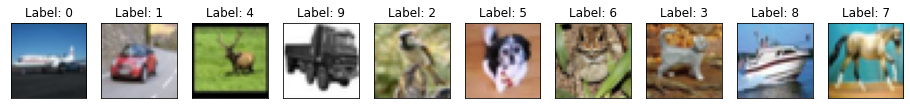

********************            10 Validation Images            ********************


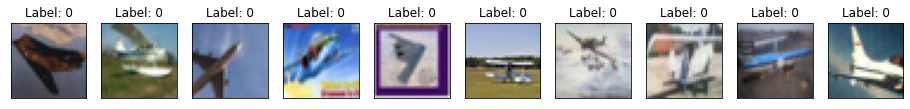

********************            10 Test Images            ********************


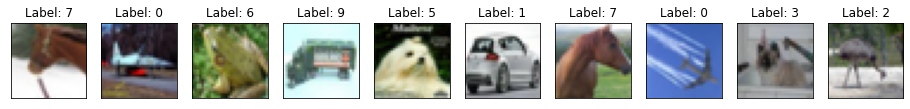

In [330]:
#@title create View_Image and Check_If_Batched function
def check_if_batched(ds, batch):
  if (ds.__class__.__name__ !='BatchDataset') and (ds._input_dataset.__class__.__name__ != 'BatchDataset') and (ds._input_dataset._input_dataset.__class__.__name__ !='BatchDataset'):
      return ds.batch(10)
  else:
    return ds

def view_image(ds, opttext = "", batch = 10):
# this function takes the dataset and automatically displays 10 figures
# the dataset has to be batches to see the images
  ds  = check_if_batched(ds, batch)

  image, label = next(iter(ds)) # extract 1 batch from the dataset
  image = image.numpy().astype("uint8")  #??  #if theres a better way to do this I'm all ears because it's costly
  label = label.numpy()   
  

  fig = plt.figure(figsize=(16, 16))
  for i in range(10):
    if i == 1:
        print("*"*20, " "*10, opttext, " "*10,  "*"*20)
    ax = fig.add_subplot(1, 10, i+1, xticks=[], yticks=[])
    ax.imshow(image[i])
    ax.set_title(f"Label: {label[i]}")
    if i == 9:
      plt.pause(0.1)  # heck yea
      


view_image(train_A, opttext = "10 Training Images")
view_image(val, opttext = "10 Validation Images")
view_image(x_test, opttext = "10 Test Images")


To integrate `albumentations` into our tensorflow pipeline we can create two functions :  
- Pipeline to apply `augmentation`.
- a function that calls the above function and pass in our data through the pipeline.
We can then wrap our 2nd Function under `tf.numpy_function` .

### Define Albumentations "Transform" Augmentation Functions (transforms = Compose([ ... ])   ) 

In [209]:
#@title def augmentfunction(df_experimentalruns, run):
IMG_SIZE = 32

def augmentfunction(df_experimentalruns, run):
    
  # Instantiate augments

  cat_probability = 1
  cont_probability = 1
  random.seed(42)

  # Assign Continuous Factors Levels by Run -------------------------

  shift_limit_x_left =  df_experimentalruns.loc[run,"shiftX"]
  shift_limit_x_right = df_experimentalruns.loc[run,"shiftX"]  
  assert shift_limit_x_right >= shift_limit_x_left
  assert shift_limit_x_right <= 1  #more than one is damaging
  print("Shift X: (", shift_limit_x_left, ",", shift_limit_x_right, ") or (",-shift_limit_x_right, ",", -shift_limit_x_left, ")" )

  shift_limit_y_left = df_experimentalruns.loc[run,"shiftY"]
  shift_limit_y_right = df_experimentalruns.loc[run,"shiftY"]  
  assert shift_limit_y_right >= shift_limit_y_left
  assert shift_limit_y_right < 1  #more than one is damaging
  print("Shift Y: (", shift_limit_y_left, ",", shift_limit_y_right, ")or (", -shift_limit_y_right, ",", -shift_limit_y_left, ")")


  gamma_left =  df_experimentalruns.loc[run,"gamma"]     
  gamma_right = df_experimentalruns.loc[run,"gamma"]  
  assert gamma_right >= gamma_left
  print("Gamma: (", gamma_left, ",", gamma_right, ")")

  zoom_out_left = -df_experimentalruns.loc[run,"zoomOut"]  
  zoom_out_right = -df_experimentalruns.loc[run,"zoomOut"] 
  assert zoom_out_right >= zoom_out_left
  print("ZoomOut: (", zoom_out_left, ",", zoom_out_right, ")")


  zoom_in_left = df_experimentalruns.loc[run,"zoomin"]
  zoom_in_right = df_experimentalruns.loc[run,"zoomin"]
  assert zoom_in_right >= zoom_in_left
  assert zoom_in_right < 1.0
  print("ZoomIn: (", zoom_in_left, ",", zoom_in_right, ")")



  noise_left = df_experimentalruns.loc[run,"noise"]             # df_factors["Noise"][df_experimentalruns.loc[run,"Noise"]])
  noise_right = df_experimentalruns.loc[run,"noise"]         #  need to change noise to larger number
  assert noise_right >= noise_left
  print("Noise: (", noise_left, ",", noise_right, ")")


  ## Is blur of 7 too high? :-\ 
  if df_experimentalruns.loc[run,"blur"] == 0:
    blur_probability = 0
    # print("blur is 0")
    blur_left = 0
    blur_right = 0+1
  else:
    # print("blur is not 0")
    blur_probability = 1
    blur_left = df_experimentalruns.loc[run,"blur"]
    blur_right = df_experimentalruns.loc[run,"blur"]
  assert blur_right >= blur_left
  assert blur_right > 0  # must be an integer  #I can't see a dfference using 7 and 9!
  print("blur: (", blur_left, ",", blur_right, ")")


  # Need to add Sharp to the menu of options
  sharp_left = df_experimentalruns.loc[run,"sharpen"]
  sharp_right = df_experimentalruns.loc[run,"sharpen"]
  assert sharp_right >= sharp_left
  print("sharp: (", sharp_left, ",", sharp_right, ")")


  contrast_limit_left = df_experimentalruns.loc[run,"contrast"]
  contrast_limit_right = df_experimentalruns.loc[run,"contrast"]
  assert contrast_limit_right >= contrast_limit_left
  print("Contrast: (", contrast_limit_left, ",", contrast_limit_right, ")")


  brightness_limit_left = df_experimentalruns.loc[run,"brighten"]
  brightness_limit_right = df_experimentalruns.loc[run,"brighten"] 
  assert brightness_limit_right >= brightness_limit_left
  print("Bright: (", brightness_limit_left, ",", brightness_limit_right, ")")

  darkness_limit_left = -df_experimentalruns.loc[run,"darken"] 
  darkness_limit_right = -df_experimentalruns.loc[run,"darken"]
  assert darkness_limit_right >= darkness_limit_left
  print("Darken: (", darkness_limit_left, ",", darkness_limit_right, ")")


  rotate_left  = df_experimentalruns.loc[run,"rotate"]
  rotate_right = df_experimentalruns.loc[run,"rotate"]
  assert rotate_right >= rotate_left
  print("Rotate: (", rotate_left, ",", rotate_right, ") or (",-rotate_right, ",", -rotate_left, ")" )


  crop_value = 32-df_experimentalruns.loc[run,"crop"]


  # Assign Categorical Factors Probabilities to make "on" or "off" -------------------------
  pHorizontalFlip =   df_experimentalruns.loc[run,"flipH"]
  print("pHorizontalFlip: ", pHorizontalFlip)

  pVerticalFlip =     df_experimentalruns.loc[run,"flipV"]
  print("pVerticalFlip: ", pVerticalFlip)

  pEqualize =          df_experimentalruns.loc[run,"equalize"]
  print("pEqualize: ", pEqualize)

  pFancyPCA =          df_experimentalruns.loc[run,"fancyPCA"]
  print("pFancyPCA: ", pFancyPCA)

  pChannelShuffle =   df_experimentalruns.loc[run,"channelShuffle"]
  print("pChannelShuffle: ", pChannelShuffle)

  pElasticTransform =  df_experimentalruns.loc[run,"elasticTransform"]
  print("pElasticTransform: ", pElasticTransform)

  pToGray =            df_experimentalruns.loc[run,"togray"]
  print("pToGray: ", pToGray)

  background_value = 0

   
  #transforms = A.Compose([
  list_of_transforms = [


      #1. Shift Horizontally Right or Shift Horizontally Left
      A.OneOf([
                A.geometric.ShiftScaleRotate(rotate_limit=0, shift_limit_y=0, 
                                                  shift_limit_x=(shift_limit_x_left,shift_limit_x_right), 
                                                  scale_limit=0, border_mode=cv2.BORDER_CONSTANT, value=background_value),    
                A.geometric.ShiftScaleRotate(rotate_limit=0, shift_limit_y=0, 
                                                  shift_limit_x=(-shift_limit_x_right,-shift_limit_x_left), 
                                                  scale_limit=0, border_mode=cv2.BORDER_CONSTANT, value=background_value)], 
              p=cont_probability),
      
      
      # 2 Shift VERTICALLY  up or down 
      A.OneOf([
                A.geometric.ShiftScaleRotate(rotate_limit=0, shift_limit_y=(shift_limit_y_left,shift_limit_y_right), shift_limit_x=0, scale_limit=0, border_mode=cv2.BORDER_CONSTANT, value=background_value),   
                A.geometric.ShiftScaleRotate(rotate_limit=0, shift_limit_y=(-shift_limit_y_right, -shift_limit_y_left), shift_limit_x=0, scale_limit=0, border_mode=cv2.BORDER_CONSTANT, value=background_value)], 
              p =cont_probability),
      
      #3 NOISE ---------------------------------
      A.transforms.GaussNoise(var_limit=(noise_left,noise_right), p=cont_probability),  

      #4 BLUR
      A.transforms.GaussianBlur(blur_limit=(blur_left,blur_right), sigma_limit=(0.5,0.05), p=blur_probability),  #Blur
      
      #5 Sharpen 
      A.transforms.Sharpen(alpha=(sharp_left,sharp_right), lightness=(0.0, 0.0), p=cont_probability),  #AntiBlur keep lightness constant at 0?
        
      #6 Contrast
      A.transforms.RandomBrightnessContrast(brightness_limit=(0,0), contrast_limit=(contrast_limit_left,contrast_limit_right), p=cont_probability),       

      #7 Brightness
      A.transforms.RandomBrightnessContrast(brightness_limit=(brightness_limit_left,brightness_limit_right), contrast_limit=(0,0), p=cont_probability),      
      
      #8 Darkness
      A.transforms.RandomBrightnessContrast(brightness_limit=(darkness_limit_left,darkness_limit_right), contrast_limit=(0,0), p=cont_probability),  #darkness

      #9 GAMMA
      # A.transforms.RandomGamma(gamma_limit=(gamma_left,gamma_right), p=cont_probability),  
      

      #10 Zoom Out
      A.geometric.ShiftScaleRotate(rotate_limit=0,  shift_limit_y=0, shift_limit_x=0, scale_limit=(zoom_out_left,zoom_out_right), border_mode=cv2.BORDER_CONSTANT, value=background_value, p=cont_probability),    #Zoom Out safe: scale_limit=(-0.15,-0.1)

      #11  Rotate CW or CCW
      A.OneOf([
                    A.geometric.SafeRotate(limit=(rotate_left,rotate_right), border_mode=cv2.BORDER_CONSTANT, value=background_value),
                    A.geometric.SafeRotate(limit=(-rotate_right,-rotate_left), border_mode=cv2.BORDER_CONSTANT, value=background_value)], p=1),
      
      #12  Crop then Pad
      A.crops.transforms.CenterCrop(height=crop_value, width=crop_value,  p=cont_probability),       # Crop 24,24 is the extreme
      A.transforms.PadIfNeeded(min_height=32, min_width=32,  border_mode=cv2.BORDER_CONSTANT, value=background_value, p=1),

      # 13 ZoomIn
      A.geometric.ShiftScaleRotate(rotate_limit=0, shift_limit_y=0, shift_limit_x=0,
                                    scale_limit=(zoom_in_left,zoom_in_right), border_mode=cv2.BORDER_CONSTANT, value=background_value, p=cont_probability),  

      # 14 FlipH
      A.HorizontalFlip(p=pHorizontalFlip),
      
      # 15 FlipVert
      A.VerticalFlip(p=pVerticalFlip),
      
      #16 FANCY PCA
      A.transforms.FancyPCA(alpha=0.1, p=pFancyPCA),                    # FancyPCA Amount to perturn eigenvalues not Categorical
      
      #17 Elastic Transform
      A.geometric.ElasticTransform(alpha=0.1, sigma=0.001, alpha_affine=0.001, 
                                    same_dxdy=True, border_mode=cv2.BORDER_CONSTANT, 
                                    value=background_value, p=pElasticTransform),    #Seems more like a blur than a transform?
      
      # #Resize to 32x32 for crop
      # A.geometric.Resize(height=32, width=32, p=1),

      #18 Histogram Equalizer
      A.transforms.Equalize(p=pEqualize),  

      #19 CHANNELSHUFFLE
      A.transforms.ChannelShuffle(p=pChannelShuffle),  #this is prob going to ruin accuracy


      #20 Turn Everything Gray
      A.transforms.ToGray(p=pToGray)

    ] 
    
  return list_of_transforms



no_transforms = A.Compose([
         A.transforms.NoOp()
])

### Define another function "Augment_Function" to push images throguh list of "Transforms" to create augmented images

In [210]:
#@title aug_fn
def aug_fn(image, img_size):
    data = {"image":image}
    aug_data = transforms(**data)
    aug_img = aug_data["image"]
    # aug_img = tf.cast(aug_img/255.0, tf.float32)
    # aug_img = tf.cast(aug_img/1.0, tf.float32)    #attempt
    aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
    # aug_img = tf.cast(aug_img*255.0, tf.float32)
    return aug_img

def no_aug_fn(image, img_size):
    data = {"image":image}
    aug_data = no_transforms(**data)
    aug_img = aug_data["image"]
    # aug_img = tf.cast(img/255.0, tf.float32)  
    # aug_img = tf.cast(img/1.0, tf.float32)      #new attempt
    aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
    # aug_img = tf.cast(aug_img*255.0, tf.float32)
    return aug_img

#### Define Process_Data function to returns augmented image andlabel

In [211]:
#@title process_data { form-width: "20px" }
def process_data(image, label, img_size):
    aug_img = tf.numpy_function(func=aug_fn, inp=[image, img_size], Tout=tf.float32)  # was tf.float32
    return aug_img, label


def no_process_data(image, label, img_size):
    no_aug_img = tf.numpy_function(func=no_aug_fn, inp=[image, img_size], Tout=tf.float32)   # was tf.float32
    return no_aug_img, label
    

#### Restoring dataset shapes. 
The datasets loses its shape after applying a tf.numpy_function, so this is necessary for the sequential model and when inheriting from the model class.

In [212]:
#@title set_shapes
def set_shapes(img, label, img_shape=(IMG_SIZE,IMG_SIZE,3)):
    img.set_shape(img_shape)
    label.set_shape([])
    return img, label

`Note`: 
Some `API's` of `tensorflow.keras.Model` might not work, if you dont map the dataset with the set_shapes function.

## Create New Training Group Data by Merging Un-Augmented with Augmented Data


********************            train_A_noalb - No Augmentations            ********************


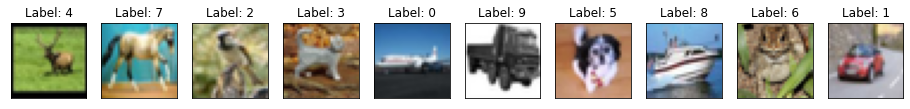


 There are **  10 **  images in Train_A_No_Augmentations before batching 

 Train_A_noAlb Class Count: (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)


In [296]:
#@title  augment_data(dataset, process, dataset_text="")
unbatch_train_A = (tf.data.Dataset.unbatch(train_A))

def augment_data(dataset, process, dataset_text=""):
  dataset_new = dataset.map(partial(process, img_size=IMG_SIZE))
  dataset_new = dataset_new.map(set_shapes)
  # dataset_new = dataset_new.batch(batchsize)
  # get_min_max(dataset,      text= dataset_text)
  # get_min_max(dataset_new,  text=str("New" + dataset_text))
  return dataset_new



In [331]:
#@title View No Augmentation Dataset { form-width: "20%" }
train_A_noalb = augment_data(dataset = unbatch_train_A, 
                             process= no_process_data,
                            #  batchsize=100,
                             dataset_text = "train_A_noalb")



********************            Train Set A - No Augmentations            ********************


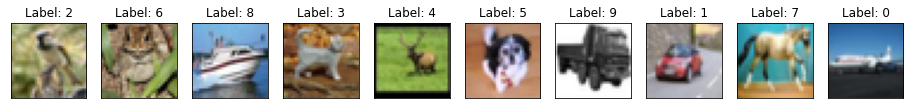

Total:  10   images counted in this dataset 
Class Count: (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)
**********************************************************************************************


In [332]:
#@title PrettyViewofData Function { form-width: "30px" }
def pretty_display_of_dataset(ds, dstitle = "Dataset title", opttext = ""):
  view_image(ds, dstitle) 
  num = ds.reduce(np.int64(0), lambda x,_ : x + 1).numpy()  # returns 25, but 25*100batches = 2500
  print("Total: ", num, "  images counted in this dataset", opttext )
  print("Class Count:", count_cifar10_class(ds))
  print("**********************************************************************************************")

pretty_display_of_dataset(train_A_noalb, "Train Set A - No Augmentations")


#### View_Num_Images Function, default num = 20

In [344]:
def view_num_images(ds, num = 20):

  ds = check_if_batched(ds, batch = num)

  image, label = next(iter(ds)) # extract 1 batch from the dataset
  image = image.numpy().astype("uint8")  #??  #if theres a better way to do this I'm all ears because it's costly
  label = label.numpy()   
  

  fig = plt.figure(figsize=(10, 10))
  for i in range(num):
      ax = fig.add_subplot(1, num, i+1, xticks=[], yticks=[])
      ax.imshow(image[i])
      ax.set_title(f"Lbl: {label[i]}")
      

In [345]:
def show_confusion_matrix(test_labels, predictions, CLASSES):
    """Compute confusion matrix and normalize."""
    confusion = sklearn.metrics.confusion_matrix(test_labels, predictions,  labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    
    confusing_part_matrix= np.array(confusion)-np.identity(confusion.shape[0])*np.diag(confusion)
  
    axis_labels = CLASSES

    ax = sns.heatmap(
        confusing_part_matrix, xticklabels=axis_labels, yticklabels=axis_labels,
        cmap='Blues', annot=True, square=True, fmt='.0f')

    plt.title("Confusion matrix without Diagonal")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")


In [346]:
# The augmented data returns floats between 0 and 1
# The unaugmented data is integers uint8 between 0 and 255 
CLASSES = info.features['label'].names

# This may help me one day with trying to get into the ID of each batch/mislabelled image
# info.features['id']


def cache_prefetch_group(train_tf, SHUFFLE=5000, batch = 0):
    # I choose to shuffle the entire deck, which probably adds time, but I want to ensure mixed unaugmented and augmented
    train_tf = train_tf.shuffle(SHUFFLE, reshuffle_each_iteration=True, seed = SEED)  # I took out seed=seed to get variety with each reshuffle
    train_tf = train_tf.cache().prefetch(buffer_size=AUTOTUNE)
    if batch != 0:
      train_tf = train_tf.batch(batch)  # ??moved Batch to inside ModelTraining loop to prevent Double-Batching-Weirdness
    return train_tf 



#### Make Confusion Matrix Functions

In [347]:
# define function to print out all the labels amd accuracies on the diagonal of the confusion matrix
def make_accuracy_dictionary(cm_norm):
  dictionary = {}
  for i in range(10):
    dictionary[CLASSES[i]] = cm_norm[i,i]
    
  # sort the values - ty SO https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value/613218#613218
  for w in sorted(dictionary, key=dictionary.get, reverse=True):
    print(w, dictionary[w])
  return dictionary 


# define function to print out all the labels amd accuracies on the off diagonal of the confusion matrix
# to indicate the most common mistakes:

# def make_misclassification_dictionary(cm):
#   dictionary = {}

#   for i in range(10):
#     dictionary_cm_diagonal_labels[CLASSES[i]] = cm_norm[i,i]
    
#   # sort the values - ty SO https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value/613218#613218
#   for w in sorted(dictionary_cm_diagonal_labels, key=dictionary_cm_diagonal_labels.get, reverse=True):
#     print(w, dictionary_cm_diagonal_labels[w])
#   return dictionary_cm_diagonal_labels 

# Run, Model, Test, Capture all 50 Designed Runs

In [348]:
## This is code found on SO to see whether the dataset is batched or not
#  
# train_A_alb.batch(num_alb).__class__.__name__

# new_train_A = new_train_A.batch(10)

# new_train_A._input_dataset.__class__.__name__

# new_train_A = (tf.data.Dataset.unbatch(new_train_A))

In [349]:
def count_images(ds, opttext = ""):
  # The number of images present in the new train_A_alb set is equal to the original set
  num_images = ds.reduce(np.int64(0), lambda x,_ : x + 1).numpy()  # returns 10 bc no batches
  print(" There are ** ", num_images, "** total images in " ,  opttext)
  return num_images


 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
Begin Run:  0

 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
Dropout is:  0.5
Shift X: ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y: ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma: ( 100 , 100 )
ZoomOut: ( -0.0 , -0.0 )
ZoomIn: ( 0.0 , 0.0 )
Noise: ( 0 , 0 )
blur: ( 0 , 1 )
sharp: ( 0.0 , 0.0 )
Contrast: ( 0.0 , 0.0 )
Bright: ( 0.0 , 0.0 )
Darken: ( -0.0 , -0.0 )
Rotate: ( 0 , 0 ) or ( 0 , 0 )
pHorizontalFlip:  0
pVerticalFlip:  0
pEqualize:  0
pFancyPCA:  0
pChannelShuffle:  0
pElasticTransform:  0
pToGray:  0
 There are **  10 ** total images in  Augmented-train-a, before batching
Train_A_Alb has class count: (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)
 There are **  10 ** total images in  Not-Augmented Train_A, before batching
Train_A_No_Augmentations has class count: (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)
********************            New Training Set

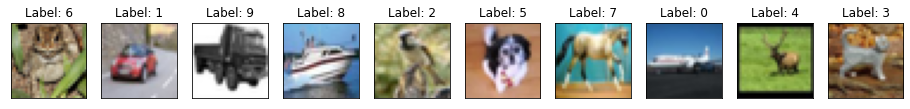

Total:  20   images counted in this dataset 
Class Count: (2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)
**********************************************************************************************
New_Train_A (concatenation of augment and non-augment)  (2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)


NameError: ignored

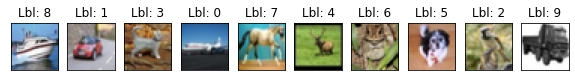

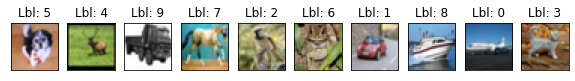

In [350]:
# ---------------------------------------------------------------------------
# Create Training-Group-Specific Dictionary to collect important metrics at the end of all runs 
# ----------------------------------------------------------------------------
Group_A_Runs = {}   #dictionary

# Group_A_Runs[run] = {'TestAccuracy': 0}


# ---------------------------------------------------------------------------
# When in troubleshooting or refining/code mode, I only run 5 experimental runs but
# when running the full design matrix, ensure ENDRUNS = 51  (50 + baseline run)
# the for loop will go through each run like this: df_experimentalruns.loc[run, "WhateverFactors"]:
# ----------------------------------------------------------------------------

ENDRUNS = 5

for run in range(0,ENDRUNS): 
  # assert ENDRUNS = 50

  # run = run + 1  # commented out after I added a Do-Nothing Run, I now have a real index 0 in the test-run-matrix  
  print("\n", (str(run) + " ")*50)
  print("Begin Run: ", run)
  print("\n", (str(run) + " ")*50)
  

  #Use my vanilla CNN model function to build a  model with a certain dropout level
  model = makemodel(DROPOUT=df_experimentalruns.loc[run,'dropout'])

# ------------------------------------
# Create Run-Specific Transformations 
# ------------------------------------

  # build  Albumentations list of transformations by passing each run's required parameters 
  list_of_transforms = augmentfunction( df_experimentalruns, run )

  # pass the list of transforms to Albumentations Compose function
  transforms = A.Compose(transforms = list_of_transforms)
  
# ------------------------------------
# Create Augmented Dataset train_A_alb 
# ------------------------------------
  
  # Augment the unbatched Training_Group_A through the Process_Data Function to create train_A_alb (albu = albumentations/augmentations)
  train_A_alb = augment_data(dataset = unbatch_train_A, process= process_data, dataset_text = "Augmented Dataset")
  
# ------------------------------------
# Print the number of total images in each unbatched dataset train_A_alb, and train_A_noalb 
# -----------------------------------

  # The number of images present in the new train_A_alb set is equal to the original set
  num_alb = count_images(train_A_alb, opttext="Augmented-train-a, before batching")
  print("Train_A_Alb has class count:", count_cifar10_class(train_A_alb))
 

  # The number of images present in the new train_A_alb set is equal to the original set
  count_images(train_A_noalb, "Not-Augmented Train_A, before batching")
  print("Train_A_No_Augmentations has class count:", count_cifar10_class(train_A_noalb))
 

  # ------------------------------------
  # Merge/Concatenate Augmented and Non-Augmented into dataset: NEW_TRAIN_A,  then return the total count of images 
  # ------------------------------------
  new_train_A = train_A_alb.concatenate(train_A_noalb)
  pretty_display_of_dataset(new_train_A, "New Training Set A - Merged")

# ------------------------------------
# Batch Consolidated Dataset and View Images per Batch
# ------------------------------------
  #  view_images()  only works on BATCHED datasets so I added a ck if batched command within that fux

  # View the images in one batch of train_A_alb  and train_A_noalb
  view_num_images(ds = train_A_alb, num = num_alb)
  view_num_images(ds = train_A_noalb, num = num_noalb)
  print("New_Train_A (concatenation of augment and non-augment) ", count_cifar10_class(new_train_A))

  

  new_train_A_batch = 10  #to test whether multiple batches are going through?

  new_train_A = cache_prefetch_group(new_train_A,  SHUFFLE=tot_new_train_A, batch=new_train_A_batch)

  # # If I ask how many images are in the new_train_A dataset, it will only give me the number of batches (images/batchsize)

  tot_new_train_A_num_of_batches = count_images(new_train_A, opttext=str("there are number of batches with batch size: " +  str(new_train_A_batch)) )

   

   
  # print("The following  calls are to view some images are of the New_Train_A group using batch size 10.  Please note pictures don't always show up exactly after this text. ")
 
  #I try to view images of the new_train_A batch and the next batch
  view_num_images(new_train_A.skip(0), 10)  # it only takes the first five each time
  view_num_images(new_train_A.skip(1), 10)  #I believe SKIP(1) means skip 1 batch, not 1 image as I originally thought


  # view_image(new_train_A.batch(10))   # didnt work isnt able to call if batched...  
  

  # I want to view more than 10 at a time, so I create a new view_image function that can supposably do that, 
  # I'm guessing the first one will fail because I have batch sizes of 10
  # view_num_images(new_train_A, num = 20)

  # I might need to unbatch and then batch these, next
  # new_train_A = new_train_A.batch(20) 
 
  # Attempt to view new_Train_A sets images 20 at a time given the new batch size
  # view_num_images(new_train_A, num = 20)
 
  # take the created model from passing dropout, and pass the training data through it
  modeltrained = trainmodel(MODEL = model, TRAININGDATA= new_train_A)


  # Retrieve the TEst Loss and Accuracy after training is complete
  loss, acc = modeltrained.evaluate(x_test, verbose=0) 
  print("TestLoss: ", loss, " TestAcc:", acc)


  #Get the predictions of Y_hat from passing X_Test into the model
  y_pred = modeltrained.predict(x_test)

  # The Y_Hats are y_pred of continuous probabilities into a 1-coded label vectors
  y_pred_1hot = np.argmax(y_pred, axis=1)
  cm = confusion_matrix(y_true = y_test, y_pred = y_pred_1hot,  labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] ) 
  cm_norm = confusion_matrix(y_true = y_test, y_pred = y_pred_1hot,  labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], normalize ='true' ) 
  # disp = ConfusionMatrixDisplay(cm, display_labels=['airplane', 'automobile','bird','cat','deer','dog','frog','horse','ship','truck']).plot()
  make_dictionary(cm_norm)

  # confusion_matrix(y_true = y_test, y_pred = y_pred_1hot )
  # show_confusion_matrix(y_test, y_pred_1hot, CLASSES = CLASSES)

  Group_A_Runs[run] = {'TestAccuracy': acc, 'TestLoss': loss, 'CM': cm, 'CM_norm': cm_norm}
  
  if run%25 == 0:  #When i =25,50, save/download file
    with open('runs_groupA.pkl', 'wb') as fid:
        pickle.dump(Group_A_Runs, fid)
        files.download('runs_groupA.pkl')
        
        timetoprint = datetime.datetime.now().strftime("%a, %d %B %Y %H:%M:%S")
        print("Download attempted : ", timetoprint, " (subtract 3-hours from Hour), and file is called runs_groupA.pkl ")

        
 

# Time Required



In [ ]:
stop_testing = time.time()
print((stop_testing - tic) , "secs to  run everything start to end, or... ")
print((stop_testing - tic)/60, "minutes ... or ")
print((stop_testing - tic)/3600, "hours ")

# Post-Test: View Results

After the 50 runs above have run, its time to load the results into JMP to Fit the Definitive Screening Design and find which Main Effects have the most compeling effect.  This is my second time running the results of Training_Group_A.  The first time I created two for loops to go through the first 25 runs and save, and then the second 25 runs and save.  When I went through my results, the second 25 runs on average were slightly less test accuracy (diff of 0.03 according to block effect), and you could clearly see that each run of view_images(data) resulted in the exact same images.  So my belief is that for some reason, maybe due to a coding issue, or maybe just an artifact of calling up the dataset-augmentations "twice", the second 25 runs in the original "[Test1](https://github.com/RachelRamirez/CIFAR-10/blob/main/CollectionofTests/Test1GroupA.ipynb)" resulted in a visible block effect.  It was funny because I had made a block variable and then accidentally caused a significant blocking effect.. ANYWHO...  


In [ ]:
import pickle
import numpy as np
with open('runs_groupA (4).pkl', 'rb') as fid:
     lastruns_groupA_loaded = pickle.load(fid)  #this file originally saved 11-5-2021 from 1 each testset

lastruns_groupA_loaded

string_of_cm = ""
y = {}


print("Run ,", "Test Accuracy ,", "Test Loss,", "Confusion Matrix Diagonals," )
for i in range(1,2):
  for x in range(10):
    string_of_cm = string_of_cm + np.array2string(lastruns_groupA_loaded[i]["CM"][x][x]) + ","
    y[i] = lastruns_groupA_loaded[i]['TestAccuracy'], lastruns_groupA_loaded[i]["TestLoss"], string_of_cm 
  print(y[i])
  string_of_cm = ""

lastruns_groupA_loaded[1]["TestAccuracy"]
lastruns_groupA_loaded[1]["CM"][:,0].sum()  #666 Predicted Class 0?
lastruns_groupA_loaded[1]["CM"][0,:].sum()  #1000 True Class 0?
lastruns_groupA_loaded[1]["CM"][1,:].sum()  #1000 True Class 1?

sum_of_cm_diagonals = 0
for i in range(10):
  sum_of_cm_diagonals = sum_of_cm_diagonals + lastruns_groupA_loaded[1]["CM"][i,i]    

print("Sum of Diagonals on Confusion Matrix of Run 1: ", sum_of_cm_diagonals) #checks with TestAccuracy


#I want to find the area of greatest confusion

#create a new matrix to not ruin previious CM
confusion_matrix_wo_diagonal = lastruns_groupA_loaded[1]["CM"].copy()
 
for i in range(10):
  confusion_matrix_wo_diagonal[i,i] = 0 # set the diagonal equal to zero
print(confusion_matrix_wo_diagonal)
# for i in range(10):
#   print(i, "is most often miscategorized as ", np.argmax(confusion_matrix_wo_diagonal[:,i]), " ", max(confusion_matrix_wo_diagonal[:,i]), " times")

for i in range(10):
  print("The algorithm predicted a ", np.argmax(confusion_matrix_wo_diagonal[i,:]),"instead of a ",  i, " ", max(confusion_matrix_wo_diagonal[i,:]), "times")



print("Summing down the rows, for COLUMN total: ", confusion_matrix_wo_diagonal.sum(axis=0))
print("Summing across the columns, for ROW total: ", confusion_matrix_wo_diagonal.sum(axis=1))

something weird about the above code.  My confusion matrix looks like its lost the diagonals. I think copying to confusion_matrix_wo_diagonal didn't do a separate copy, it is just linked, so when I cleared the diagonal of confusion_matrix_wo_diagonal, it also cleared it from lastruns_groupsA_loaded[1]["CM"]


In [ ]:
lastruns_groupA_loaded[14]["CM"]

In [ ]:
confusion_matrix_wo_diagonal.sum() + sum_of_cm_diagonals

In [ ]:
string_of_cm = ""

for i in range(1,2):  # goes through first n runs with CMs
  for x in range(10): # goes through the n items in diagonal of each run.CM
    string_of_cm = string_of_cm + np.array2string(lastruns_groupA_loaded[i]["CM"][x][x]) + ","
    y[i] = lastruns_groupA_loaded[i]['TestAccuracy'], lastruns_groupA_loaded[i]["TestLoss"], string_of_cm 
  print(y[i])
  

lastruns_groupA_loaded[1]["TestAccuracy"]
lastruns_groupA_loaded[1]["CM"][:,0].sum()  #666 Predicted Class 0
lastruns_groupA_loaded[1]["CM"][0,:].sum()  #1000 True Class 0
lastruns_groupA_loaded[1]["CM"][1,:].sum()  #1000 True Class 1

sum_of_cm_diagonals = 0
for i in range(10):
  sum_of_cm_diagonals = sum_of_cm_diagonals + lastruns_groupA_loaded[1]["CM"][i,i]    

print("Sum of Diagonals on Confusion Matrix of Run 1: ", sum_of_cm_diagonals) #checks with TestAccuracy


#I want to find the area of greatest confusion

#create a new matrix to not ruin previious CM
confusion_matrix_wo_diagonal = lastruns_groupA_loaded[1]["CM"].copy()
 
for i in range(10):
  confusion_matrix_wo_diagonal[i,i] = 0 # set the diagonal equal to zero
print(confusion_matrix_wo_diagonal)
# for i in range(10):
#   print(i, "is most often miscategorized as ", np.argmax(confusion_matrix_wo_diagonal[:,i]), " ", max(confusion_matrix_wo_diagonal[:,i]), " times")

for i in range(10):
  print("The algorithm predicted a ", np.argmax(confusion_matrix_wo_diagonal[i,:]),"instead of a ",  i, " ", max(confusion_matrix_wo_diagonal[i,:]), "times")



print("Summing down the rows, for COLUMN total: ", confusion_matrix_wo_diagonal.sum(axis=0))
print("Summing across the columns, for ROW total: ", confusion_matrix_wo_diagonal.sum(axis=1))